# Exploratory Data Analysis

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from physclass.signal import compute_spectrum

**Load data**

In [2]:
df_lab = pd.read_csv('../data/raw/labels.csv')
df = pd.read_csv('../data/raw/time_series.csv')

In [3]:
df_lab.head(3)

,id,subject,session,start_time,sampling_freq,label
0,sub-001_ses-01_respiratory_chest,sub-001,ses-01,-36.338306,20,respiratory_chest
1,sub-001_ses-01_trigger,sub-001,ses-01,-36.338306,20,trigger
2,sub-001_ses-01_cardiac,sub-001,ses-01,-36.338306,20,cardiac


In [4]:
df.head(3)

,sub-001_ses-01_respiratory_chest,sub-001_ses-01_trigger,sub-001_ses-01_cardiac,sub-001_ses-01_respiratory_CO2,sub-001_ses-01_respiratory_O2,sub-001_ses-02_respiratory_chest,sub-001_ses-02_trigger,sub-001_ses-02_cardiac,sub-001_ses-02_respiratory_CO2,sub-001_ses-02_respiratory_O2,...,sub-009_ses-09_trigger,sub-009_ses-09_cardiac,sub-009_ses-09_respiratory_CO2,sub-009_ses-09_respiratory_O2,sub-009_ses-10_respiratory_chest_broken,sub-009_ses-10_respiratory_chest_ppg,sub-009_ses-10_trigger,sub-009_ses-10_cardiac,sub-009_ses-10_respiratory_CO2,sub-009_ses-10_respiratory_O2
0,0.912476,0.000916,-0.057678,0.129089,0.174255,-1.373901,0.000000,-0.093994,0.108643,0.177918,...,0.001221,-0.083313,0.148621,0.191040,-0.001221,-0.054016,0.000610,0.133362,0.204163,0.194092
1,0.911865,0.001221,0.005798,0.146790,0.173950,-1.515503,0.000610,-0.100708,0.117188,0.176697,...,0.000916,-0.109863,0.161438,0.190735,-0.001831,-0.051880,0.000000,0.102844,0.197449,0.193787
2,0.928040,0.001526,0.090942,0.166016,0.173340,-1.665649,0.000916,-0.101013,0.128174,0.175781,...,0.000916,-0.131531,0.173035,0.191040,-0.000916,-0.050049,0.001831,0.081177,0.191650,0.193176


**Basic info about the data**


In [5]:
n_sample = df.shape[0]
n_signal = df.shape[1]
print(f'Total number of signals: {n_sample}')
print(f'Total number of signals: {n_signal}')

df_lab.label.value_counts()

Total number of signals: 17299
Total number of signals: 379


trigger                     70
cardiac                     70
respiratory_CO2             70
respiratory_O2              70
respiratory_chest           41
respiratory_chest_broken    29
respiratory_chest_ppg       29
Name: label, dtype: int64

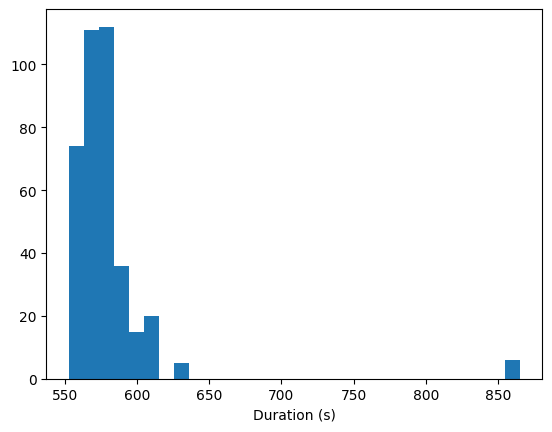

In [6]:
t_dur = df.apply(lambda x: np.sum(x == x)) / 20
fig, ax = plt.subplots()
ax.hist(t_dur, 30)
_ = ax.set_xlabel('Duration (s)')

**Visualize a single signal**

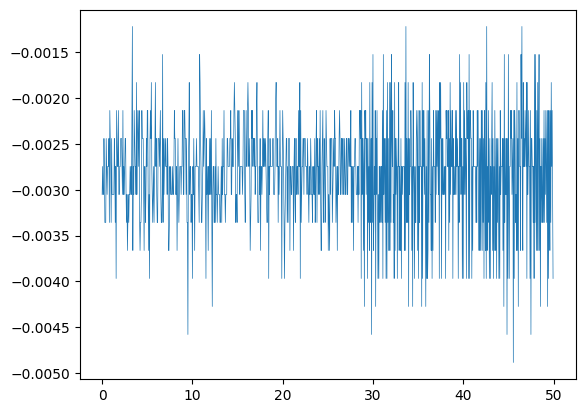

In [7]:
idx = 30
y = df.iloc[:, idx]
t = np.arange(0, 17299/20, 1/20)
fig, ax = plt.subplots()
ax.plot(t[:1000], y[:1000], linewidth=0.5)

**Visualize a bunch of signals**

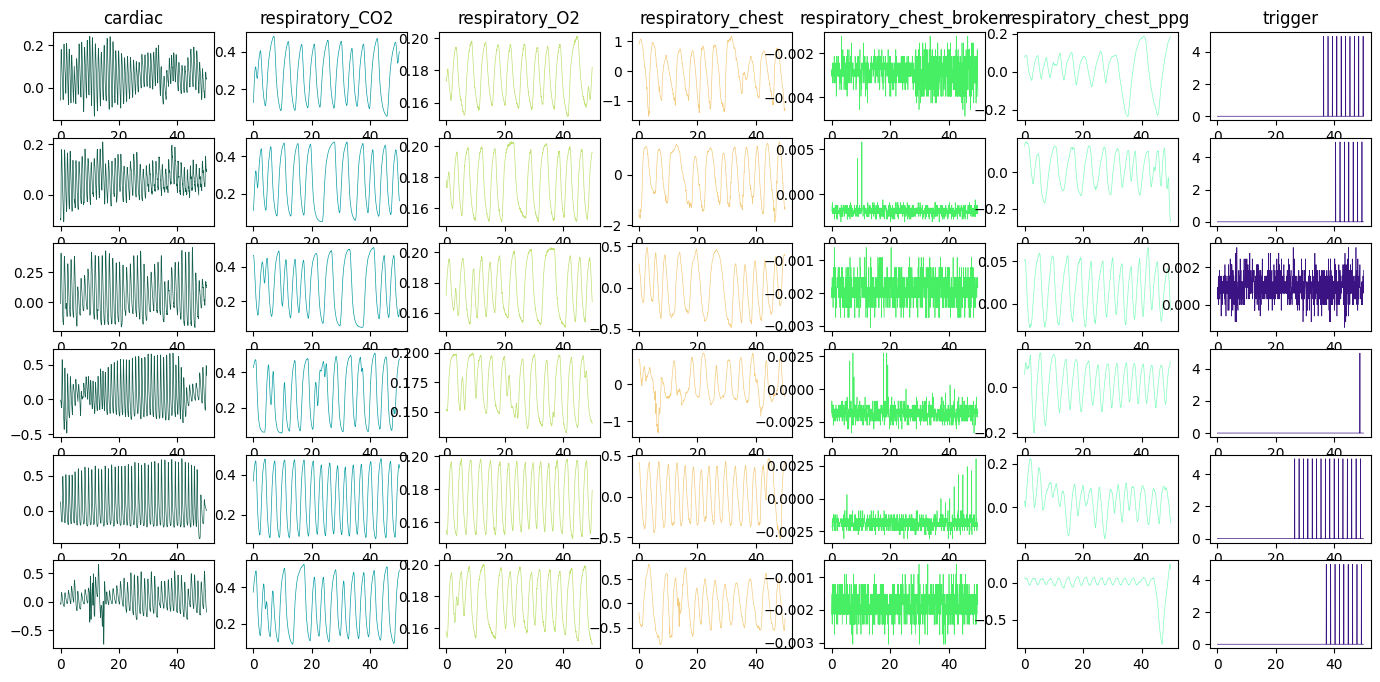

In [8]:
classes = np.unique(df_lab.label)

n_col = len(classes)
n_row = 6
n_samp = 1000

fig, ax = plt.subplots(n_row, n_col, figsize=(17,8))

for i_col, label in enumerate(classes):
    subset = df.loc[:, [classes[i_col] in i for i in df.columns]]
    color = np.random.rand(3)
    
    for i_row in range(n_row):
        y = subset.iloc[:, i_row]
        ax[i_row, i_col].plot(t[:n_samp], y[:n_samp], color=color, linewidth=0.5)
        if i_row == 0:
            ax[i_row, i_col].set_title(classes[i_col])

**Time-domain analysis**

In [9]:
df_td = pd.DataFrame({'mean': df.apply(lambda x: np.mean(x)),
                      'min':  df.apply(lambda x: np.min(x)),
                      'max':  df.apply(lambda x: np.max(x)),
                      'std':  df.apply(lambda x: np.std(x)),
                      'snr':  df.apply(lambda x: np.mean(x) / np.std(x))})

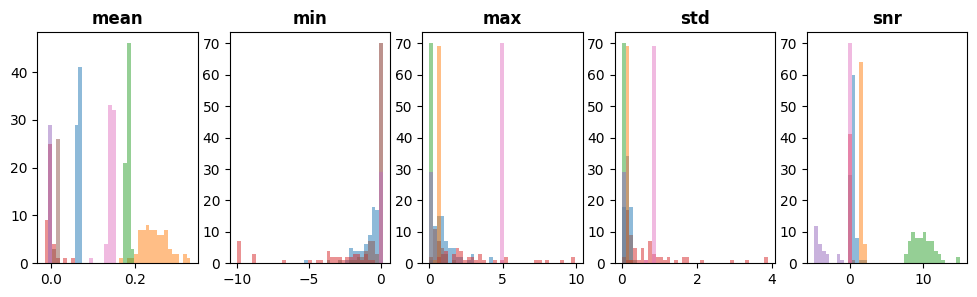

In [10]:
fig, ax = plt.subplots(1,5,figsize=(12,3))
for i_col, var in enumerate(df_td.columns):
    for label in classes:
        y = df_td[var].values
        bins = np.linspace(np.min(y), np.max(y), 40)
        ax[i_col].hist(y[df_lab.label == label], bins, alpha=0.5)
    ax[i_col].set_title(df_td.columns[i_col], fontweight='bold', fontsize=12)

Text(0, 0.5, 'std')

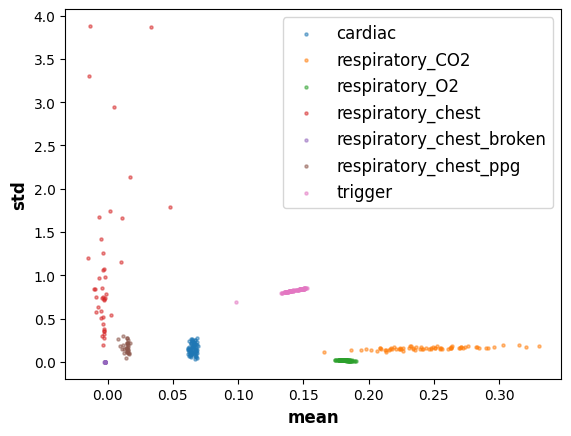

In [21]:
fig, ax = plt.subplots()
for label in classes:
    y1 = df_td['mean'].values
    y2 = df_td['std'].values
    ax.scatter(y1[df_lab.label == label], y2[df_lab.label == label], 5, alpha=0.5)
    
# X, Y = np.meshgrid(np.linspace(-0.1, 0.4, 50), np.linspace(0.001, 4, 50))
# Z = np.log10((X / Y)**2)
# ax.contour(X, Y, Z, linewidths=0.2)
ax.legend(classes, fontsize=12)
ax.set_xlabel('mean', fontweight='bold', fontsize=12)
ax.set_ylabel('std', fontweight='bold', fontsize=12)

**Frequency analysis**

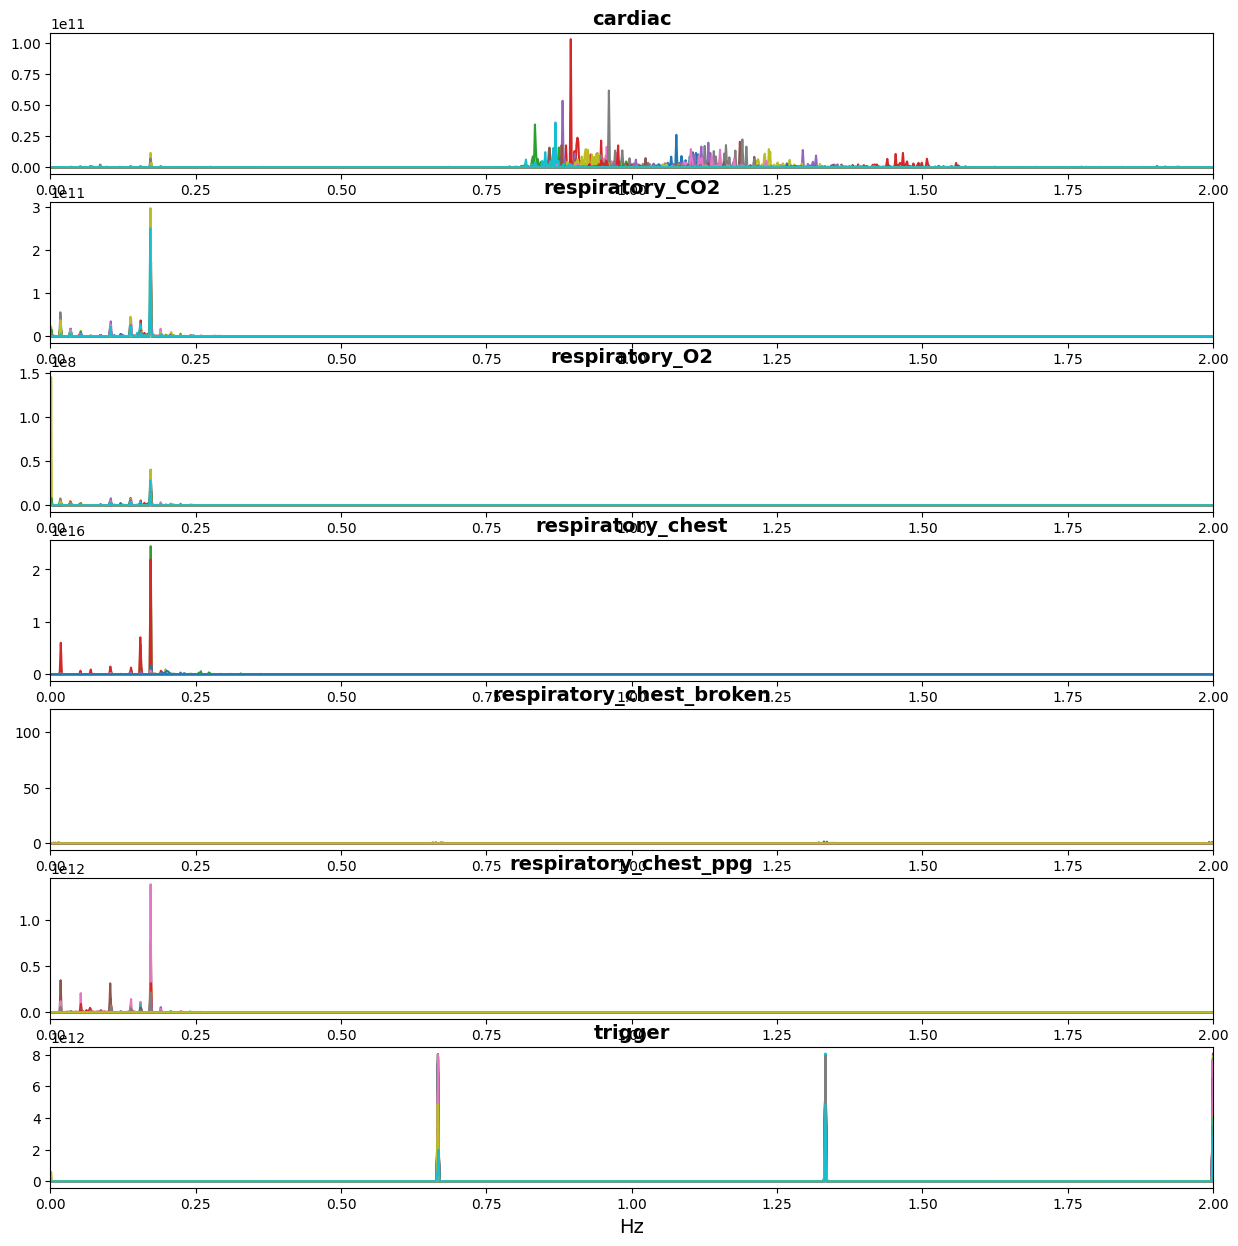

In [17]:
fig, ax = plt.subplots(len(classes), figsize=(15,15))

for i_row, label in enumerate(classes):
    idx_class = df_lab.index[df_lab.label == label]
    df_class = df.iloc[:, idx_class]

    for i_s in range(df_class.shape[1]):        
        s = df_class.iloc[:, i_s].values
        s = s[s == s]
        f, hf = compute_spectrum(s, 20)        
        ax[i_row].plot(f, hf) 
    ax[i_row].set_xlim(0,2)
    ax[i_row].set_title(label, fontsize=14, fontweight='bold')
    if i_row == len(classes) - 1:
        ax[i_row].set_xlabel('Hz',fontsize=14)